In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append('../utils/')
import qubo_utils as qutils 
# The 3D-RISM density slices are saved as pickled files in the folder MUP1.
# They are indexed by a number (see d_list) which represents the distance in Angstrom
# from the central slice.

d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]

# import slices
path = "../MUP1/MUP1_logfilter8_slices/"
basename = "_density_slice_MUP1_logfilter8.p"
densities = qutils.density_slices(d_list=d_list, basename=basename, path=path)

# import slice coordinates (these are 3D coordinates in
# angstroms, they are needed at the very end to map
# excited qubits to positions in the protein cavity)
path = "../MUP1/MUP1_logfilter8_points/"
basename = "_plane_points_MUP1.p"
points = qutils.plane_points(d_list=d_list, basename=basename, path=path)

# The register associated to each slide can be found in the folder nb/registers.
# Two types of files are saved there:
# - position_<#>.npy: the positions of the qubits in micrometers, as if they were in the QPU
# - rescaled_position_<#>.npy: the positions of the qubits on the same scale as the density slices

# import registers
path = "registers/"
basename = "position_"
positions = qutils.register_positions(d_list=d_list, basename=basename, path=path)

basename = "rescaled_position_"
rescaled_positions = qutils.rescaled_positions(d_list=d_list, basename=basename, path=path)

In [148]:
from qiskit.quantum_info import Pauli, Statevector
from qiskit.result import QuasiDistribution
from qiskit.quantum_info import SparsePauliOp
def sample_most_likely(state_vector: QuasiDistribution | Statevector) -> np.ndarray:
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = qutils.bitfield(k, n)
    x.reverse()
    return np.asarray(x)

def get_Ising_hamiltonian(qubo: np.ndarray) -> SparsePauliOp:
    #the constant term (coefficient in front of II...I)
    coeff_id = 0.5*np.sum([qubo[i][i] for i in range(len(qubo))])+0.5*np.sum([np.sum([qubo[i][j] for j in range(i+1,len(qubo))]) for i in range(len(qubo))])

    #the linear terms (coefficient in front of I ... I sigma^z_i I ... I)
    coeff_linear = [0.5*np.sum([qubo[i][j] for j in range(len(qubo))]) for i in range(len(qubo))]

    #the quadratic terms (coefficient in front of I ... I sigma^z_i I ... I sigma^z_j I ... I)
    coeff_quadratic = 0.25*qubo

    #creat the list of sparse pauli operators and coefficients
    sparse_list = [(qutils.sparse_sigmaz_string(len(qubo), []), coeff_id)]

    for i in range(len(qubo)):
        sparse_list.append((qutils.sparse_sigmaz_string(len(qubo), [i]), coeff_linear[i]))
        for j in range(len(qubo)):
            if i != j:
                sparse_list.append((qutils.sparse_sigmaz_string(len(qubo), [i, j]), coeff_quadratic[i][j]))

    I2 = SparsePauliOp.from_list(sparse_list)

    return I2

In [110]:
from qiskit_algorithms.utils import algorithm_globals

# for reproducable results
algorithm_globals.random_seed = 3

qubo_matrices = qutils.get_qubo_matrices(densities=densities, rescaled_positions=rescaled_positions)
qubo = qubo_matrices[0] # use the first slice as an example to solve

# get the corresponding Ising Hamiltonian
ising_ham = get_Ising_hamiltonian(qubo=qubo)

In [111]:
#QAOA approach

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import Estimator, Sampler

# SciPy minimizer routine
from scipy.optimize import minimize

%config InlineBackend.figure_format='retina'

from qiskit import transpile 
from qiskit import Aer

backend = Aer.get_backend('aer_simulator')


In [169]:
qubo = qubo_matrices[0] # use the first slice as an example to solve

# get the corresponding Ising Hamiltonian
ising_ham = get_Ising_hamiltonian(qubo=qubo)

# Problem to Hamiltonian operator
hamiltonian =  ising_ham
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=6)
# Draw
#ansatz.decompose(reps=3).draw("mpl")
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost


estimator = Estimator(options={"shots": int(1e4)})
sampler = Sampler(options={"shots": int(1e4)})

In [174]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="SLSQP")
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.09610950622044834
       x: [ 1.073e+04 -3.006e+03  5.274e+03  3.579e+02  1.199e+04
            6.441e+03  1.181e+04  2.482e+03  1.055e+04 -1.311e+04
            1.663e+02  1.359e+04]
     nit: 57
     jac: [ 5.034e+04 -7.907e+04  6.184e+04 -5.505e+03  1.973e+04
           -8.175e+04 -1.556e+05 -1.068e+05 -1.626e+05  3.189e+04
           -1.277e+05  1.319e+05]
    nfev: 1312
    njev: 57

In [175]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()

In [176]:
# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
x=sample_most_likely(samp_dist)
print(f'x is {x}')
xnot = [(int(b)+1)%2 for b in x]
#xnot = [0] + xnot
print(f'xnot is {xnot}')
print(qutils.Ising_energy(x, qubo))
print(qutils.Ising_energy(xnot, qubo))

x is [1 1 0 1]
xnot is [0, 0, 1, 0]
0.2542989353777042
-0.008651546963556501


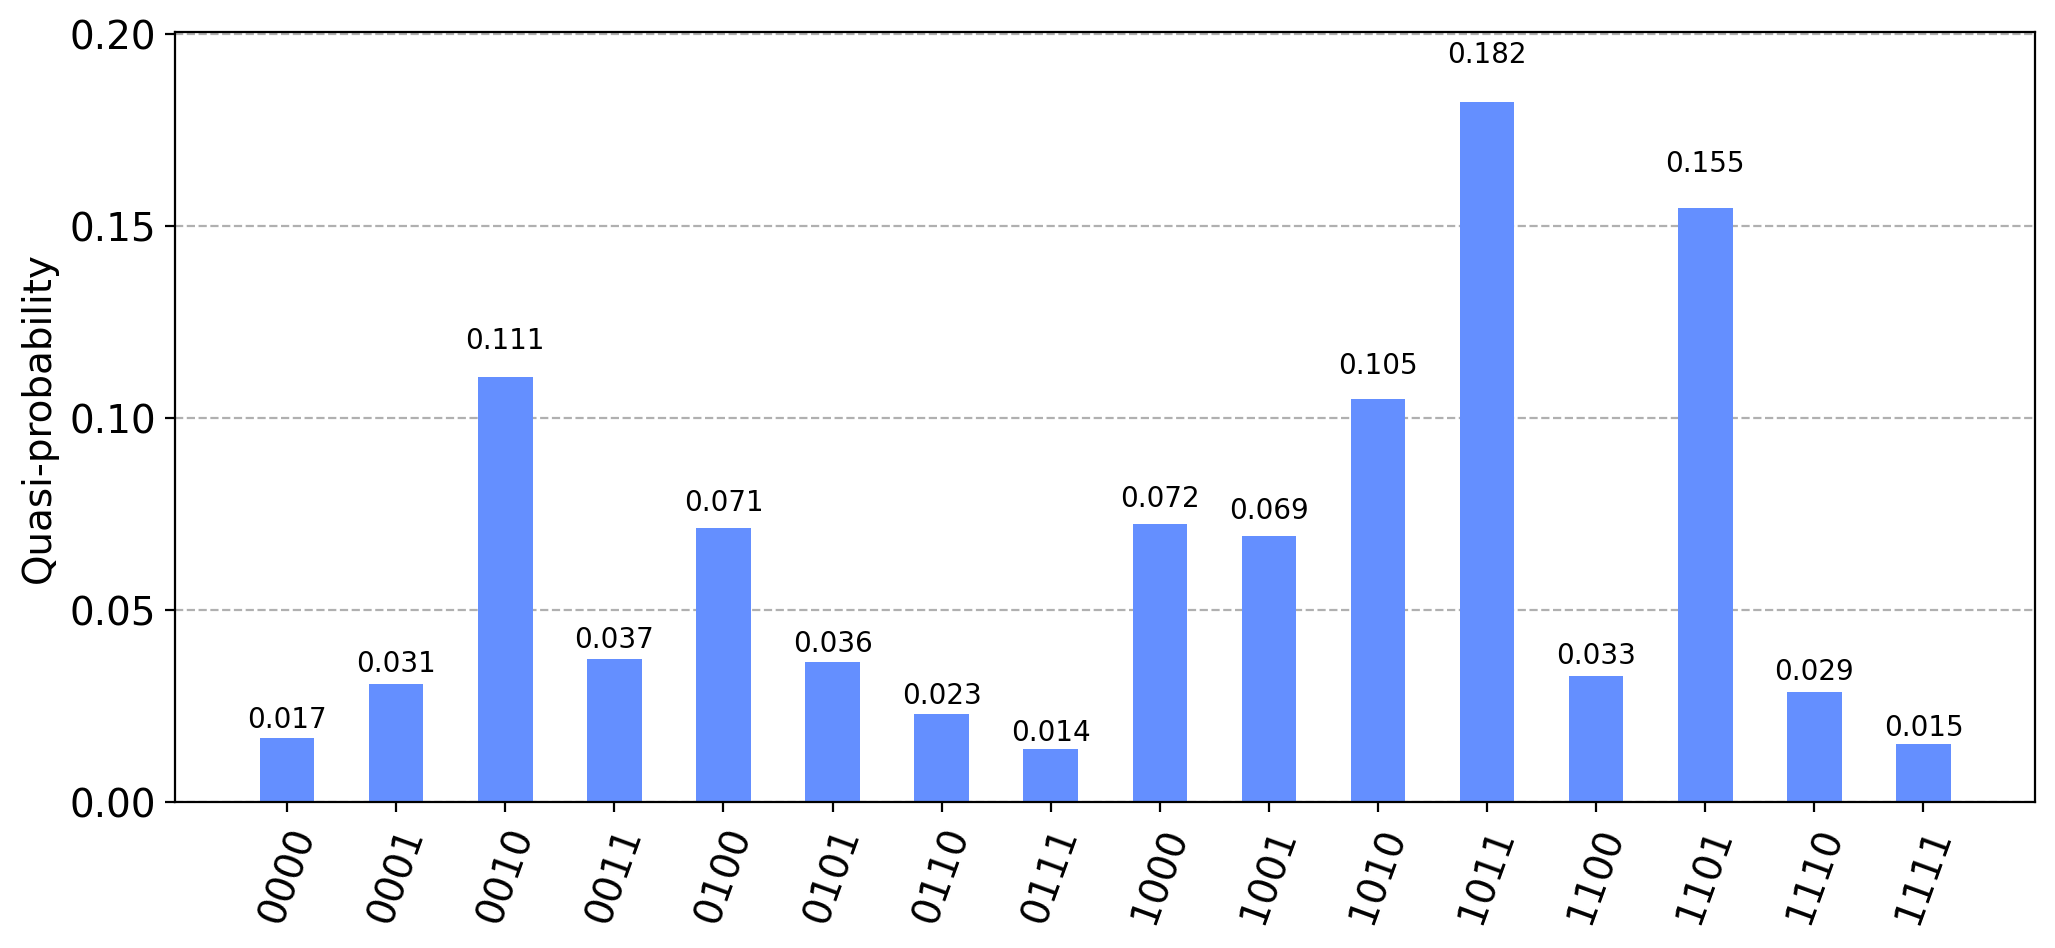

In [177]:
plot_distribution(samp_dist.binary_probabilities(), figsize=(12, 5))

In [10]:
samp_dist

{0: 0.0002, 1: 0.021, 2: 0.0417, 3: 0.2199, 4: 0.0533, 5: 0.2621, 6: 0.0342, 7: 0.1571, 8: 0.0046, 9: 0.0248, 10: 0.0052, 11: 0.0736, 12: 0.0116, 13: 0.0562, 14: 0.001, 15: 0.0335}